# HANK-SAM Tutorial: General Equilibrium Analysis of Fiscal Policy

**Authors**: Christopher D. Carroll and William Du, based on Carroll, Crawley, Du, Frankovic, and Tretvoll (2025)

📄 **Paper**: [Welfare and Spending Effects of Consumption Stimulus Policies](https://llorracc.github.io/HAFiscal-Public/)

📦 **Source Code**: [`dashboard/hank_sam.py`](dashboard/hank_sam.py) contains all model block definitions

🎛️ **Interactive Dashboard**: [`dashboard/app.ipynb`](dashboard/app.ipynb) — explore the model with adjustable parameters

🛠️ **Built with**: [HARK](https://github.com/econ-ark/HARK) (Heterogeneous Agents Resources & toolKit) and [sequence-jacobian](https://github.com/shade-econ/sequence-jacobian)

---

## Table of Contents

1. [Model Setup](#part-1-model-setup) — Labor market calibration and GE parameters
2. [GE Blocks](#specify-general-equilibrium-blocks) — Sequence-space Jacobian model components
3. [Household Jacobians](#part-2-household-jacobians) — Pre-computed heterogeneous agent responses
4. [Model Assembly](#part-3-model-assembly) — Combining blocks into full HANK-SAM model
5. [Policy Experiments](#part-4-policy-experiments) — UI extensions, stimulus checks, tax cuts
6. [Fiscal Multipliers](#computing-fiscal-multipliers) — NPV calculations and comparisons
7. [Results Visualization](#multipliers-by-monetary-policy-regime) — IRFs and multiplier plots
8. [Summary](#summary-comparison-to-main-paper-results) — Key takeaways and paper comparison
9. [HARK Resources](#hark-resources-for-further-learning) — Documentation and examples

---

## Prerequisites

**Required packages:**
```
pip install sequence_jacobian numpy scipy matplotlib econ-ark
```

**Runtime:** Full notebook execution takes approximately 30-60 seconds on a modern laptop.

---

## Overview

This tutorial demonstrates the **HANK-SAM** (Heterogeneous Agent New Keynesian with Search and Matching) model from [Section 5](https://llorracc.github.io/HAFiscal-Public/#x1-340005) of the paper. 

**What you'll learn:**
- How to construct a general equilibrium model using sequence-space Jacobians
- How different fiscal policies (UI extensions, stimulus checks, tax cuts) compare
- How monetary policy regimes affect fiscal multipliers

---

## The HARK Toolkit

This tutorial builds on the [**HARK**](https://econ-ark.org) (Heterogeneous Agents Resources & toolKit) ecosystem:

| Resource | Description | Link |
|----------|-------------|------|
| **HARK Documentation** | Comprehensive guide to the toolkit | [docs.econ-ark.org](https://docs.econ-ark.org) |
| **Gentle Introduction** | Beginner-friendly overview for economists | [econ-ark.org/materials/gentle-intro-to-hark](https://econ-ark.org/materials/gentle-intro-to-hark/) |
| **ConsIndShockModel** | Individual income shocks & consumption | [IndShockConsumerType](https://docs.econ-ark.org/reference/ConsumptionSaving/ConsIndShockModel.html) |
| **ConsAggShockModel** | Aggregate shocks in HA models | [AggShockConsumerType](https://docs.econ-ark.org/reference/ConsumptionSaving/ConsAggShockModel.html) |
| **DemARK** | Demonstrations and examples | [github.com/econ-ark/DemARK](https://github.com/econ-ark/DemARK) |
| **Materials Library** | REMARKs & teaching resources | [econ-ark.org/materials](https://econ-ark.org/materials/) |

**Why HARK matters for this tutorial:**
- The pre-computed household Jacobians come from HARK's consumption-saving models
- HARK handles the heterogeneous agent problem (income risk, borrowing constraints, wealth distribution)
- The MPC distribution that drives fiscal multiplier differences is a HARK output

**A key advantage of using HARK:** Because the micro model was solved using HARK, we can leverage HARK's built-in tools that allow turning **any micro model with a general equilibrium steady-state into a dynamic macro model**. This is accomplished by:
1. Calculating household Jacobians (how consumption/wealth respond to aggregate shocks) using HARK's `calcJacobian()` methods
2. Pairing these Jacobians with the [sequence-jacobian (SSJ) toolkit](https://github.com/shade-econ/sequence-jacobian) to embed household responses into general equilibrium frameworks

This methodology is **generalizable** to HARK's extensive collection of structural micro models (see [HARK model catalog](https://docs.econ-ark.org/reference/index.html#consumption-saving-models)), including ConsIndShockModel, ConsGenIncProcessModel, ConsPortfolioModel, and many others. The same recipe — solve the micro model, compute Jacobians, define GE blocks, assemble and solve — can transform any HARK steady-state equilibrium into a dynamic macro model.

---

## Interactive Dashboard

For **hands-on exploration** without writing code, use the [Interactive Dashboard](dashboard/app.ipynb):

| Feature | Description |
|---------|-------------|
| **Real-time parameter adjustment** | Modify Taylor rule coefficients (φ_π, φ_y), wage rigidity, fiscal adjustment speed |
| **Multiple monetary regimes** | Switch between Taylor rule, fixed nominal rate, and fixed real rate |
| **Three fiscal policies** | Compare UI extensions, stimulus checks, and tax cuts side-by-side |
| **Visual outputs** | Multiplier plots and consumption IRFs update automatically |

**Launch options:**
- **Local**: Run `voila dashboard/app.ipynb` from the project root
- **Cloud**: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llorracc/HAFiscal-Latest/master?urlpath=voila%2Frender%2Fdashboard%2Fapp.ipynb) (zero setup required)

This tutorial provides the **educational foundation** for understanding what the dashboard computes.


In [1]:
# Import necessary libraries
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Import utilities (plotting + calibration loading)
from HANK_and_SAM_tutorial_utils import (
    load_steady_state,
    build_steady_state_dict,
    plot_multipliers_three_experiments,
    plot_consumption_irfs_three_experiments,
    plot_consumption_irfs_three,
    plot_consumption_irf,
    plot_consumption_multipliers,
)

# Load all steady-state parameters (silently injects alpha, phi_ss, C_ss, etc.)
load_steady_state(globals())

---

## Part 1: Model Setup

<a id="part-1-model-setup"></a>

### 1.1 Labor Market Calibration

The HANK-SAM model includes a **search-and-matching labor market** ([Appendix A](https://llorracc.github.io/HAFiscal-Public/#x1-37000A)):

| Parameter | Value | Description | Source |
|-----------|-------|-------------|--------|
| Job finding rate | 2/3 per quarter | Probability unemployed worker finds job | U.S. CPS data |
| Steady-state unemployment | ~3% | Long-run unemployment rate | Calibrated |
| Job separation | Endogenous | Depends on labor market tightness | Model solution |

These parameters govern how unemployment responds to fiscal shocks. See [Section 3.3.1](https://llorracc.github.io/HAFiscal-Public/#x1-210003.3.1) for the full calibration.


In [2]:
# Markov transition matrix for labor market dynamics
# Rows: current state [Employed, U1, U2, U3, U4, U5+]
# Cols: next state    [Employed, U1, U2, U3, U4, U5+]
# (Parameters job_find, job_sep loaded via load_steady_state)

markov_array_ss = np.array([
    #  To: Employed             U1                    U2                    U3                    U4                    U5+
    [1 - job_sep*(1-job_find),  job_find,             job_find,             job_find,             job_find,             job_find            ],  # From: Employed
    [job_sep * (1 - job_find),  0.0,                  0.0,                  0.0,                  0.0,                  0.0                 ],  # From: U1
    [0.0,                       (1 - job_find),       0.0,                  0.0,                  0.0,                  0.0                 ],  # From: U2
    [0.0,                       0.0,                  (1 - job_find),       0.0,                  0.0,                  0.0                 ],  # From: U3
    [0.0,                       0.0,                  0.0,                  (1 - job_find),       0.0,                  0.0                 ],  # From: U4
    [0.0,                       0.0,                  0.0,                  0.0,                  (1 - job_find),       (1 - job_find)      ],  # From: U5+
])

mrkv_temp_for_will = markov_array_ss

### 1.2 Unemployment Jacobians

We compute how unemployment responds to changes in job-finding rates. This captures the **labor market dynamics** of fiscal policy.

**Why Jacobians?** The Jacobian ∂U/∂θ tells us how unemployment in each duration bucket responds to changes in labor market tightness (θ). This is computed analytically from the Markov transition matrix, avoiding costly numerical differentiation.


In [ ]:
# Jacobians for unemployment rate by duration


def create_matrix_U(dx):
    """Create Markov matrix with perturbed job-finding rate."""
    job_find_dx = job_find + dx

    markov_array = np.array([
        #  To: Employed                  U1                      U2                      U3                      U4                      U5+
        [1 - job_sep*(1-job_find_dx),    job_find_dx,            job_find_dx,            job_find_dx,            job_find_dx,            job_find_dx           ],  # From: Employed
        [job_sep * (1 - job_find_dx),    0.0,                    0.0,                    0.0,                    0.0,                    0.0                   ],  # From: U1
        [0.0,                            (1 - job_find_dx),      0.0,                    0.0,                    0.0,                    0.0                   ],  # From: U2
        [0.0,                            0.0,                    (1 - job_find_dx),      0.0,                    0.0,                    0.0                   ],  # From: U3
        [0.0,                            0.0,                    0.0,                    (1 - job_find_dx),      0.0,                    0.0                   ],  # From: U4
        [0.0,                            0.0,                    0.0,                    0.0,                    (1 - job_find_dx),      (1 - job_find_dx)     ],  # From: U5+
    ])

    return markov_array


dx = 0.0001  # Finite difference step size

dstn = ss_dstn

bigT = 300  # Dimension of Jacobian matrix (bigT x bigT)
UJAC = np.zeros((num_mrkv, bigT, bigT))

for s in range(bigT):
    for i in range(bigT):
        if i == s:
            tranmat = create_matrix_U(dx)
            dstn = np.dot(tranmat, dstn)
        else:
            dstn = np.dot(mrkv_temp_for_will, dstn)

        UJAC[:, i, s] = (dstn - ss_dstn) / dx

### 1.3 General Equilibrium Parameters

These parameters govern the general equilibrium interactions:

| Category | Parameters | Paper Reference |
|----------|------------|-----------------|
| **Labor Market** | Vacancy posting cost, matching efficiency | [Appendix A](https://llorracc.github.io/HAFiscal-Public/#x1-37000A) |
| **Fiscal Policy** | Government consumption (G/Y), debt adjustment speed | [Section 2.2](https://llorracc.github.io/HAFiscal-Public/#x1-90002.2) |
| **Monetary Policy** | Taylor rule coefficients (φ_π, φ_y), interest rate smoothing (ρ_r) | [Section 5](https://llorracc.github.io/HAFiscal-Public/#x1-340005) |
| **Price Setting** | Calvo probability, price adjustment costs | [Section 5](https://llorracc.github.io/HAFiscal-Public/#x1-340005) |

Most values follow standard calibrations in the HANK literature (Kaplan, Moll, Violante 2018; Auclert et al. 2021).


In [4]:
# Steady-state parameters loaded above via load_steady_state(globals())
# All GE parameters (alpha, phi_ss, C_ss, wage_ss, etc.) are now available

# Parameters tunable in dashboard mentioned above
## In case you want to explore them by hand here

In [1]:
# Policy parameters available for experimentation:
# - phi_pi, phi_y: Taylor rule coefficients
# - phi_b: Debt stabilization speed  
# - phi_w: Wage rigidity
# All loaded automatically; override by reassignment if desired

print(f"Phillips curve slope: kappa_p={kappa_p_ss:.4f}")
print(f"Taylor rule: phi_pi={phi_pi}, phi_y={phi_y}")
print(f"Fiscal rule: phi_b={phi_b}")

NameError: name 'kappa_p_ss' is not defined

---

## Specify General Equilibrium Blocks

<a id="specify-general-equilibrium-blocks"></a>

📄 **Paper Reference**: [Section 5: Robustness in a HANK and SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005)

The following blocks define the **sequence-space Jacobian** representation of the general equilibrium model. Each block is a function that maps inputs to outputs, and the `sequence_jacobian` package automatically computes derivatives.

| Block | Description | Inputs → Outputs |
|-------|-------------|------------------|
| **Labor Market** | | |
| `unemployment1` | Aggregate unemployment from duration buckets | θ → U |
| `matching` | Job finding/separation rates | θ, N → job_find, job_sep |
| `vacancies` | Vacancy posting | θ, N → v |
| `hiring_cost` | Cost of posting vacancies | v, θ → HC |
| `wage_` | Wage determination with rigidity | θ, π → w |
| `marginal_cost` | Firm marginal cost | w → MC |
| **Pricing** | | |
| `Phillips_Curve` | New Keynesian Phillips curve | MC, π → π |
| `production` | Aggregate production function | N → Y |
| **Monetary Policy** | | |
| `taylor` | Standard Taylor rule | π, Y → i |
| `taylor_lagged` | Taylor rule with smoothing | π, Y, i(-1) → i |
| `fisher_clearing` | Fisher equation (real/nominal rates) | i, π → r |
| **Fiscal Policy** | | |
| `fiscal` | Government budget constraint | G, T, B → B' |
| `fiscal_rule` | Debt stabilization rule | B → T |
| `fiscal_G` | Fiscal block for G shocks | Similar to fiscal |
| **Bond Pricing** | | |
| `longbonds_price` | Long-term bond pricing (no-arbitrage) | r → q_b |
| `ex_post_longbonds_rate` | Realized bond returns | q_b, π → r_b |
| **Market Clearing** | | |
| `mkt_clearing` | Goods market equilibrium | C, G, I → residual |

**Source code**: All blocks are defined in [`dashboard/hank_sam.py`](dashboard/hank_sam.py).


In [ ]:
import sequence_jacobian as sj
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import create_model

# Import everything we need from the HANK-SAM module
import sys
sys.path.insert(0, 'dashboard')
from hank_sam import (
    # Pre-computed Jacobians (loaded from pickle files)
    Jacobian_Dict,
    Jacobian_Dict_by_educ,
    Jacobian_Dict_UI_extend_real,
    UJAC_dict,
    
    # Labor market blocks
    unemployment1,
    marginal_cost,
    hiring_cost,
    wage_,
    matching,
    vacancies,
    
    # Pricing and monetary policy
    Phillips_Curve,
    taylor,
    taylor_lagged,
    
    # Fiscal blocks
    fiscal,
    fiscal_G,
    fiscal_rule,
    fiscal_rule_G,
    fiscal_fixed_real_rate,
    fiscal_G_fixed_real_rate,
    
    # Market clearing
    production,
    mkt_clearing,
    fisher_clearing,
    fisher_clearing_fixed_real_rate,
    
    # Long-term bond pricing
    longbonds_price,
    ex_post_longbonds_rate,
    
    # Steady state values
    N_ss, U_ss, ss_dstn, num_mrkv,
    kappa, delta, qb_ss, B_ss, Y_ss, MC_ss, wage_ss, tau_ss, 
    phi_ss, theta_ss, chi_ss, eta_ss, v_ss, HC_ss, Z_ss, G_ss, pi_ss,
    job_find, job_sep, EU_prob, alpha, R, r_ss, C_ss, A_ss, UI,
    epsilon_p, varphi, phi_pi, phi_y, rho_r, kappa_p_ss, phi_b, phi_w,
    real_wage_rigidity, bigT,
)

# Store C_ss_sim for compatibility with utils
C_ss_sim = C_ss
A_ss_sim = A_ss

print("✅ Imported from dashboard/hank_sam.py:")
print(f"   • GE blocks: unemployment1, marginal_cost, Phillips_Curve, fiscal, ...")
print(f"   • Pre-computed Jacobians: Jacobian_Dict, Jacobian_Dict_by_educ, UJAC_dict")
print(f"   • Steady state: N_ss={N_ss:.4f}, U_ss={U_ss:.4f}, Y_ss={Y_ss:.4f}")


✅ Imported from dashboard/hank_sam.py:
   • GE blocks: unemployment1, marginal_cost, Phillips_Curve, fiscal, ...
   • Pre-computed Jacobians: Jacobian_Dict, Jacobian_Dict_by_educ, UJAC_dict
   • Steady state: N_ss=0.9560, U_ss=0.0440, Y_ss=1.1553


In [ ]:
# The Jacobians are already loaded from pickle files in hank_sam.py
# No additional computation needed here

# Verify we have the key objects
print(f"Jacobian_Dict outputs: {Jacobian_Dict.outputs}")
print(f"Jacobian_Dict inputs: {Jacobian_Dict.inputs}")
print(f"UJAC_dict outputs: {UJAC_dict.outputs}")


Jacobian_Dict outputs: ['C', 'A']
Jacobian_Dict inputs: ['transfers', 'r', 'w', 'tau', 'eta', 'DiscFac', 'UI_extend', 'UI_rr']
UJAC_dict outputs: ['N', 'U1', 'U2', 'U3', 'U4', 'U5']


# Define steady state dictionary

In [8]:
# Build steady state dictionary for sequence_jacobian
SteadyState_Dict = build_steady_state_dict(SteadyStateDict, globals())

---

## Part 2: Household Jacobians

<a id="part-2-household-jacobians"></a>

### 2.1 Pre-computed Household Response Functions

The key innovation in HANK models is capturing **heterogeneous household responses** to aggregate shocks. Computing these responses requires solving a high-dimensional dynamic programming problem, which is computationally expensive.

**Why pre-compute?** Solving the full heterogeneous agent model takes hours. By pre-computing the Jacobians (∂C/∂income, ∂C/∂r, etc.) once and storing them, we can run many policy experiments in seconds.

**What's in the Jacobians:**
- **Consumption responses by wealth level** — Low-wealth households have higher MPCs ([Section 3.3.4](https://llorracc.github.io/HAFiscal-Public/#x1-240003.3.4))
- **Responses by employment status** — Unemployed households respond differently than employed
- **Intertemporal responses** — How consumption today responds to expected future income changes

The Jacobians are loaded from pickle files generated by the full HA-Fiscal model ([Section 2](https://llorracc.github.io/HAFiscal-Public/#x1-70002)).

---

### 🛠️ HARK Connection: Household Problem

The household consumption-saving problem solved to generate these Jacobians uses [HARK's ConsIndShockModel](https://docs.econ-ark.org/reference/ConsumptionSaving/ConsIndShockModel.html):

```python
# Conceptual HARK code (actual implementation in HA-Fiscal codebase)
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

agent = IndShockConsumerType(
    CRRA=2.0,              # Relative risk aversion
    DiscFac=0.96,          # Discount factor
    Rfree=1.03,            # Risk-free rate
    PermShkStd=[0.1],      # Permanent income shock std
    TranShkStd=[0.1],      # Transitory shock std
    UnempPrb=0.05,         # Unemployment probability
    IncUnemp=0.3,          # Income when unemployed (UI replacement rate)
)
agent.solve()
```

**Key HARK concepts used:**
| Concept | HARK Implementation | Role in This Tutorial |
|---------|---------------------|----------------------|
| **Idiosyncratic income risk** | `PermShkStd`, `TranShkStd` | Generates precautionary saving, wealth distribution |
| **Unemployment risk** | `UnempPrb`, `IncUnemp` | Creates high-MPC unemployed households |
| **Borrowing constraints** | `BoroCnstArt` | Prevents consumption smoothing, raises MPCs |
| **Consumption function** | `cFunc` | Maps (wealth, income) → consumption |

For more on these models, see:
- [IndShockConsumerType Documentation](https://econ-ark.org/materials/indshockconsumertype/)
- [Gentle Introduction to HARK](https://econ-ark.org/materials/gentle-intro-to-hark/)


In [9]:
import pickle  # Import pre-computed Jacobians from the HA-Fiscal model

# =============================================================================
# Load Household Jacobians from HA-Fiscal Model  
# Source: Code/HA-Models/FromPandemicCode/HA-Fiscal-HANK-SAM.py
# =============================================================================

obj = open("Code/HA-Models/FromPandemicCode/HA_Fiscal_Jacs.obj", "rb")
HA_fiscal_JAC = pickle.load(obj)
obj.close()

# -----------------------------------------------------------------------------
# Jacobian_Dict: Standard household response Jacobians
# -----------------------------------------------------------------------------
# These Jacobians capture how aggregate Consumption (C) and Assets (A) respond
# to various policy shocks. The key inputs are:
#   - transfers:  Lump-sum transfers (stimulus checks)
#   - tau:        Tax rate changes (payroll tax cuts)
#   - UI_extend:  Extended UI benefits (to long-term unemployed U3, U4)
#   - UI_rr:      UI replacement rate changes
#   - eta:        Job-finding probability shocks
#   - w:          Wage shocks
#
# In this version, ALL households anticipate the UI extension policy:
# employed and short-term unemployed adjust savings knowing they would
# receive extended benefits IF they become long-term unemployed.
Jacobian_Dict = JacobianDict({"C": HA_fiscal_JAC["C"], "A": HA_fiscal_JAC["A"]})

CJACs_by_educ = HA_fiscal_JAC["C_by_educ"]  # By education: dropout/highschool/college
AJACs_by_educ = HA_fiscal_JAC["A_by_educ"]


# -----------------------------------------------------------------------------
# Jacobian_Dict_UI_extend_real: "Realized" UI extension Jacobians
# Source: Code/HA-Models/FromPandemicCode/HA_Fiscal_Jacs_UI_extend_real.obj
# -----------------------------------------------------------------------------
# CRITICAL DISTINCTION from standard Jacobian_Dict:
#
# Standard UI_extend: Households anticipate the policy. When UI extension is
#   announced, ALL households (even employed ones) adjust behavior, because
#   they value the insurance: "If I become long-term unemployed, I'll get
#   extended benefits." This reduces precautionary saving economy-wide.
#
# UI_extend_real ("realized"): Only households who ACTUALLY become long-term
#   unemployed (U3, U4) respond to the policy. No anticipation effect—employed
#   and short-term unemployed don't change behavior. This captures the scenario
#   where the insurance value of the policy is ignored, measuring only the
#   direct effect on realized recipients.
#
# The "realized" version gives a lower multiplier because it misses the
# precautionary savings channel that operates even for non-recipients.

obj = open("Code/HA-Models/FromPandemicCode/HA_Fiscal_Jacs_UI_extend_real.obj", "rb")
UI_extend_realized_Jacs = pickle.load(obj)
obj.close()

Jacobian_Dict_UI_extend_real = deepcopy(
    JacobianDict({"C": HA_fiscal_JAC["C"], "A": HA_fiscal_JAC["A"]})
)
# Override UI_extend Jacobians with "realized" versions (no anticipation):
Jacobian_Dict_UI_extend_real["C"]["UI_extend"] = UI_extend_realized_Jacs["C"]["UI_extend_real"]
Jacobian_Dict_UI_extend_real["A"]["UI_extend"] = UI_extend_realized_Jacs["A"]["UI_extend_real"]


# -----------------------------------------------------------------------------
# Jacobian_Dict_by_educ: Jacobians disaggregated by education level
# -----------------------------------------------------------------------------
# These allow analysis of heterogeneous responses across education groups:
#   - dropout:    High school dropouts (lowest income, highest MPC)
#   - highschool: High school graduates
#   - college:    College graduates (highest income, lowest MPC)
Jacobian_Dict_by_educ = JacobianDict({
    "C_dropout":    CJACs_by_educ["dropout"],
    "C_highschool": CJACs_by_educ["highschool"],
    "C_college":    CJACs_by_educ["college"],
    "A_dropout":    AJACs_by_educ["dropout"],
    "A_highschool": AJACs_by_educ["highschool"],
    "A_college":    AJACs_by_educ["college"],
})


# -----------------------------------------------------------------------------
# UJAC_dict: Unemployment distribution Jacobians
# -----------------------------------------------------------------------------
# How employment/unemployment distribution responds to job-finding rate (eta):
#   N:  Employment
#   U1: Unemployed 1 quarter  (receive regular UI)
#   U2: Unemployed 2 quarters (receive regular UI)
#   U3: Unemployed 3 quarters (receive extended UI if policy active)
#   U4: Unemployed 4 quarters (receive extended UI if policy active)
#   U5: Unemployed 5+ quarters (exhausted all benefits)
UJAC_dict = JacobianDict({
    "N":  {"eta": UJAC[0]},   # Employment response to job-finding rate
    "U1": {"eta": UJAC[1]},   # Short-term unemployed (quarter 1)
    "U2": {"eta": UJAC[2]},   # Short-term unemployed (quarter 2)
    "U3": {"eta": UJAC[3]},   # Long-term unemployed (quarter 3) - extended UI eligible
    "U4": {"eta": UJAC[4]},   # Long-term unemployed (quarter 4) - extended UI eligible
    "U5": {"eta": UJAC[5]},   # Long-term unemployed (5+ quarters) - benefits exhausted
})

In [10]:
old_Jacobian_Dict = deepcopy(Jacobian_Dict)
periods = old_Jacobian_Dict["C"]["transfers"].shape[0]

do_splurge = True
if do_splurge:
    splurge = 0.3
    # Loop though Jacobians
    for jacobian_input in ["transfers", "tau", "UI_extend", "UI_rr", "eta", "w"]:
        # Calculate the present value of the policy announced for time s
        present_value = np.sum(
            (old_Jacobian_Dict["C"][jacobian_input] / R ** np.arange(periods)), axis=0
        )
        # The splurge jacobian consists of spending the value of the policy at the time that the cash arrives
        splurge_jacobian_component = np.diag(present_value * R ** np.arange(periods))
        # The total splurge jacobian is a weighted average of the spurge component and the original jacobian
        splurge_jacobian = (
            splurge * splurge_jacobian_component
            + (1 - splurge) * old_Jacobian_Dict["C"][jacobian_input]
        )
        Jacobian_Dict["C"][jacobian_input] = splurge_jacobian
        Jacobian_Dict["A"][jacobian_input] = (1 - splurge) * old_Jacobian_Dict["A"][
            jacobian_input
        ]

---

## Part 3: Model Assembly

<a id="part-3-model-assembly"></a>

### 3.1 Creating the Full HANK-SAM Model

We use the `sequence_jacobian` package ([Auclert, Bardóczy, Rognlie, Straub 2021](https://github.com/shade-econ/sequence-jacobian)) to combine all blocks into a solvable general equilibrium model.

**The assembly process:**
1. **Household block** — Pre-computed Jacobians (`Jacobian_Dict`)
2. **Firm block** — Production (`production`), pricing (`Phillips_Curve`, `marginal_cost`)
3. **Labor market** — Search and matching (`matching`, `vacancies`, `unemployment1`)
4. **Monetary policy** — Taylor rule (`taylor`) or alternatives
5. **Fiscal policy** — Budget constraint (`fiscal`, `fiscal_rule`)
6. **Market clearing** — Goods and asset markets (`mkt_clearing`, `fisher_clearing`)

**Solution method:** The model is solved in **sequence space** using automatic differentiation. Given a path of shocks, we find the path of endogenous variables that clears all markets.

We create multiple model variants for different monetary policy regimes:
- `HANK_SAM` — Standard Taylor rule
- `HANK_SAM_fixed_real_rate` — Accommodative monetary policy
- `HANK_SAM_lagged_taylor_rule` — Taylor rule with interest rate smoothing


In [11]:
HANK_SAM = create_model(
    [
        Jacobian_Dict,
        Jacobian_Dict_by_educ,
        fiscal,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule,
        production,
        matching,
        taylor,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing,
        mkt_clearing,
    ],
    name="HARK_HANK",
)


HANK_SAM_tax_rate_shock = create_model(
    [
        Jacobian_Dict,
        Jacobian_Dict_by_educ,
        fiscal_G,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule_G,
        production,
        matching,
        taylor,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing,
        mkt_clearing,
    ],
    name="HARK_HANK",
)

HANK_SAM_lagged_taylor_rule = create_model(
    [
        Jacobian_Dict,
        Jacobian_Dict_by_educ,
        fiscal,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule,
        production,
        matching,
        taylor_lagged,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing,
        mkt_clearing,
    ],
    name="HARK_HANK",
)


HANK_SAM_fixed_real_rate = create_model(
    [
        Jacobian_Dict,
        Jacobian_Dict_by_educ,
        fiscal_fixed_real_rate,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule,
        production,
        matching,
        # taylor_lagged,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing_fixed_real_rate,
        mkt_clearing,
    ],
    name="HARK_HANK",
)

HANK_SAM_fixed_real_rate_UI_extend_real = create_model(
    [
        Jacobian_Dict_UI_extend_real,
        Jacobian_Dict_by_educ,
        fiscal_fixed_real_rate,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule,
        production,
        matching,
        # taylor_lagged,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing_fixed_real_rate,
        mkt_clearing,
    ],
    name="HARK_HANK",
)


HANK_SAM_tax_cut_fixed_real_rate = create_model(
    [
        Jacobian_Dict,
        Jacobian_Dict_by_educ,
        fiscal_G_fixed_real_rate,
        longbonds_price,
        ex_post_longbonds_rate,
        fiscal_rule_G,
        production,
        matching,
        # taylor_lagged,
        Phillips_Curve,
        marginal_cost,
        UJAC_dict,
        hiring_cost,
        wage_,
        vacancies,
        unemployment1,
        fisher_clearing_fixed_real_rate,
        mkt_clearing,
    ],
    name="HARK_HANK",
)

---

## Part 4: Policy Experiments

<a id="part-4-policy-experiments"></a>

### 4.1 Comparing Three Fiscal Policies

We simulate three fiscal stimulus policies from [Section 4](https://llorracc.github.io/HAFiscal-Public/#x1-250004):

| Policy | Target Population | Mechanism | Paper Section |
|--------|-------------------|-----------|---------------|
| **UI Extension** | Unemployed (3+ quarters) | Extends benefits to exhaustees | [§4.1.2](https://llorracc.github.io/HAFiscal-Public/#x1-280004.1.2) |
| **Stimulus Checks** | All households | Lump-sum transfer | [§4.1.1](https://llorracc.github.io/HAFiscal-Public/#x1-270004.1.1) |
| **Tax Cuts** | Employed workers | Payroll tax reduction | [§4.1.3](https://llorracc.github.io/HAFiscal-Public/#x1-290004.1.3) |

**Key insight from the paper:** UI extensions have the highest fiscal multiplier because they target high-MPC households (the unemployed) and create beneficial **anticipation effects** — employed workers increase consumption knowing they'll be insured if they lose their jobs.


In [12]:
unknowns = ["theta", "r_ante"]
targets = ["asset_mkt", "fisher_resid"]
targets_goods_mkt = ["asset_mkt", "fisher_resid"]

T = bigT

---

## UI Extensions (Extended Unemployment Insurance)

📄 **Paper**: [Section 2.2: Recessions and policies](https://llorracc.github.io/HAFiscal-Public/#x1-90002.2) | [Section 4.1: Partial equilibrium](https://llorracc.github.io/HAFiscal-Public/#x1-260004.1)

**Policy**: Extend unemployment insurance benefits to workers who have been unemployed for 3+ quarters (U3, U4), who would otherwise have exhausted their regular UI benefits.

**Economic mechanism**:
- Direct effect: Provides income to long-term unemployed (high MPC households)
- Anticipation effect: Even employed workers consume more because they value the insurance against becoming long-term unemployed
- The "realized" vs "anticipated" distinction (see Jacobians below) captures whether households anticipate the policy

**Code**: `Code/HA-Models/FromPandemicCode/HA-Fiscal-HANK-SAM.py` (search for `UI_extend`)


In [ ]:
dUI_extension = np.zeros(bigT)
dUI_extension[:UI_extension_length] = (
    0.2  # Income of households with UI 0.7, income of households without UI is 0.5. Income of employed is normalized to 1.0. Note that the jacobian in the code is respect to a perturbation that accounts for wages and taxes. In particular, in the code it is: "+ dx*wage_ss*(1-tau_ss) "
)
shocks_UI_extension = {"UI_extend": dUI_extension}


SteadyState_Dict_UI_extend = deepcopy(SteadyState_Dict)
SteadyState_Dict_UI_extend["phi_b"] = phi_b  # fiscal adjustment parameter
SteadyState_Dict_UI_extend["phi_w"] = (
    real_wage_rigidity  # wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
)
SteadyState_Dict_UI_extend["rho_r"] = rho_r  # inertial parameter for taylor rule
SteadyState_Dict_UI_extend["phi_y"] = phi_y  # taylor rule coefficient on output
SteadyState_Dict_UI_extend["phi_pi"] = phi_pi  # taylor rule coefficient on inflation
SteadyState_Dict_UI_extend["deficit_T"] = (
    -1
)  # the number of periods it takes for government to adjust and follow its fiscal rule. If equal deficit_T = -40, then government will keep taxes fixed for 40 quarters


SteadyState_Dict_UI_extend_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)
SteadyState_Dict_UI_extend_fixed_nominal_rate["phi_pi"] = (
    0.0  # taylor rule does not react to inflation
)

irfs_UI_extend = HANK_SAM.solve_impulse_linear(
    SteadyState_Dict_UI_extend, unknowns, targets, shocks_UI_extension
)
irfs_UI_extend_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(
    SteadyState_Dict_UI_extend_fixed_nominal_rate,
    unknowns,
    targets,
    shocks_UI_extension,
)

---

## Taylor Rule with Interest Rate Smoothing

📄 **Paper**: [Section 5: HANK-SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005)

**Policy**: The central bank follows a Taylor rule with a lag, responding to inflation and output gap with inertia.

**Equation**: $i_t = \rho_i \cdot i_{t-1} + (1-\rho_i)[i^* + \phi_\pi \pi_t + \phi_y (Y_t - Y^*)/Y^*]$

This introduces **monetary policy inertia**, making interest rate changes gradual rather than immediate.


In [14]:
SteadyState_Dict_UI_extend_lagged_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)

monetary_policy_lag = 2
SteadyState_Dict_UI_extend_lagged_nominal_rate["lag"] = (
    monetary_policy_lag  # number of quarters the fed does not react
)
irfs_UI_extend_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(
    SteadyState_Dict_UI_extend_lagged_nominal_rate,
    unknowns,
    targets,
    shocks_UI_extension,
)

## Solve for IRF to UI extension shock under a fixed real rate

In [15]:
unknowns_fixed_real_rate = ["theta"]
targets_fixed_real_rate = ["asset_mkt"]

In [16]:
irfs_UI_extension_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(
    SteadyState_Dict_UI_extend,
    unknowns_fixed_real_rate,
    targets_fixed_real_rate,
    shocks_UI_extension,
)  # solve for IRFs

---

## Multipliers Under Fixed Real Rate

📄 **Paper**: [Section 5: HANK-SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005) | [Figure 5](https://llorracc.github.io/HAFiscal-Public/#x1-34005r5)

**Scenario**: The central bank maintains a constant real interest rate (closest to our partial equilibrium baseline).

This monetary regime abstracts from general equilibrium feedback through interest rates, isolating the pure fiscal stimulus effect. Compare these results to the partial equilibrium results in [Section 4](https://llorracc.github.io/HAFiscal-Public/#x1-250004).


In [17]:
def NPV(irf, length):  # to compute Net present value
    NPV = 0
    for i in range(length):
        NPV += irf[i] / R**i

    return NPV

In [18]:
print(
    "multiplier out of 2Q UI extension (active taylor rule)",
    NPV(irfs_UI_extend["Y"], bigT) / NPV(irfs_UI_extend["UI_extension_cost"], bigT),
)
print(
    "multiplier out of 2Q UI extension (fixed nominal rate)",
    NPV(irfs_UI_extend_fixed_nominal_rate["Y"], bigT)
    / NPV(irfs_UI_extend_fixed_nominal_rate["UI_extension_cost"], bigT),
)
print(
    "multiplier out of 2Q UI extension (fixed real rate)",
    NPV(irfs_UI_extension_fixed_real_rate["Y"], bigT)
    / NPV(irfs_UI_extension_fixed_real_rate["UI_extension_cost"], bigT),
)

multiplier out of 2Q UI extension (active taylor rule) 0.976389776340425
multiplier out of 2Q UI extension (fixed nominal rate) 1.1133581182097754
multiplier out of 2Q UI extension (fixed real rate) 1.135945905095725


In [19]:
irf_UI_extend_realizations = (
    HANK_SAM_fixed_real_rate_UI_extend_real.solve_impulse_linear(
        SteadyState_Dict_UI_extend,
        unknowns_fixed_real_rate,
        targets_fixed_real_rate,
        shocks_UI_extension,
    )
)  # solve for IRFs

---

## Stimulus Transfers (Stimulus Checks)

📄 **Paper**: [Section 2.2: Recessions and policies](https://llorracc.github.io/HAFiscal-Public/#x1-90002.2) | [Section 4.1: Partial equilibrium](https://llorracc.github.io/HAFiscal-Public/#x1-260004.1)

**Policy**: One-time lump-sum transfer to all households (like the 2020 CARES Act stimulus payments).

**Economic mechanism**:
- Immediate income boost to all households
- Higher MPC households (low wealth, unemployed) spend more of the transfer
- "Splurge" behavior: even wealthy households spend a fraction immediately
- Fastest to implement of the three policies

**Code**: `Code/HA-Models/FromPandemicCode/HA-Fiscal-HANK-SAM.py` (search for `transfers`)


In [20]:
dtransfers = np.zeros(bigT)
dtransfers[:stimulus_check_length] = (
    C_ss * 0.05
)  # Approxiate size of aggregate stimulus check spending
shocks_transfers = {"transfers": dtransfers}


SteadyState_Dict_transfer = deepcopy(SteadyState_Dict)

SteadyState_Dict_transfer["phi_b"] = phi_b
SteadyState_Dict_transfer["phi_w"] = real_wage_rigidity
SteadyState_Dict_transfer["rho_r"] = rho_r
SteadyState_Dict_transfer["phi_y"] = phi_y
SteadyState_Dict_transfer["phi_pi"] = phi_pi
SteadyState_Dict_transfer["deficit_T"] = -1

SteadyState_Dict_UI_transfer_fixed_nominal_rate = deepcopy(SteadyState_Dict_transfer)
SteadyState_Dict_UI_transfer_fixed_nominal_rate["phi_pi"] = 0.0

irfs_transfer = HANK_SAM.solve_impulse_linear(
    SteadyState_Dict_transfer, unknowns, targets, shocks_transfers
)
irfs_transfer_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(
    SteadyState_Dict_UI_transfer_fixed_nominal_rate, unknowns, targets, shocks_transfers
)

In [21]:
print(
    "multiplier out of transfers",
    NPV(irfs_transfer["Y"], bigT) / NPV(irfs_transfer["transfers"], bigT),
)

print(
    "multiplier out of transfers (fixed nominal rate)",
    NPV(irfs_transfer_fixed_nominal_rate["Y"], bigT)
    / NPV(irfs_transfer_fixed_nominal_rate["transfers"], bigT),
)

multiplier out of transfers 0.865104146510705
multiplier out of transfers (fixed nominal rate) 1.1097351656995045


---

## Lagged Taylor Rule Response

📄 **Paper**: [Section 5: HANK-SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005)

Under a standard Taylor rule, the central bank raises interest rates in response to the inflation generated by fiscal stimulus. This **dampens** the multiplier effect.

Here we show what happens when monetary policy responds with a lag, partially accommodating the fiscal expansion.


In [22]:
SteadyState_Dict_transfers_lagged_nominal_rate = deepcopy(SteadyState_Dict_transfer)

monetary_policy_lag = 2
SteadyState_Dict_transfers_lagged_nominal_rate["lag"] = (
    monetary_policy_lag  # number of quarters the fed does not react
)
irfs_transfers_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(
    SteadyState_Dict_transfers_lagged_nominal_rate, unknowns, targets, shocks_transfers
)

---

## Fixed Real Rate Scenario

📄 **Paper**: [Section 5: HANK-SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005) | [Figure 5](https://llorracc.github.io/HAFiscal-Public/#x1-34005r5)

Under a fixed real rate, the nominal rate adjusts one-for-one with expected inflation: $i_t = r^* + \mathbb{E}_t[\pi_{t+1}]$.

This eliminates the monetary policy feedback channel, providing an upper bound on fiscal multipliers.


In [23]:
irfs_transfer_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(
    SteadyState_Dict_transfer,
    unknowns_fixed_real_rate,
    targets_fixed_real_rate,
    shocks_transfers,
)  # solve for IRFs

In [24]:
print(
    "multiplier out of transfers (active taylor rule)",
    NPV(irfs_transfer["Y"], bigT) / NPV(irfs_transfer["transfers"], bigT),
)
print(
    "multiplier out of transfers (fixed nominal rate)",
    NPV(irfs_transfer_fixed_nominal_rate["Y"], bigT)
    / NPV(irfs_transfer_fixed_nominal_rate["transfers"], bigT),
)
print(
    "multiplier out of transfers (fixed real rate)",
    NPV(irfs_transfer_fixed_real_rate["Y"], bigT)
    / NPV(irfs_transfer_fixed_real_rate["transfers"], bigT),
)

multiplier out of transfers (active taylor rule) 0.865104146510705
multiplier out of transfers (fixed nominal rate) 1.1097351656995045
multiplier out of transfers (fixed real rate) 1.0965255023522824


---

## Payroll Tax Cut

📄 **Paper**: [Section 2.2: Recessions and policies](https://llorracc.github.io/HAFiscal-Public/#x1-90002.2) | [Section 4.1: Partial equilibrium](https://llorracc.github.io/HAFiscal-Public/#x1-260004.1)

**Policy**: Temporary (8-quarter) reduction in payroll taxes, increasing take-home pay for employed workers.

**Economic mechanism**:
- Only benefits employed workers (unlike UI extensions and stimulus checks)
- Lower MPCs among employed vs unemployed → smaller immediate spending response
- Takes longer to distribute compared to lump-sum transfers
- Effect depends on labor supply elasticity and wage rigidity

**Why it underperforms**: Tax cuts go to employed households who have lower MPCs and lower marginal utility compared to unemployed households.

**Code**: `Code/HA-Models/FromPandemicCode/HA-Fiscal-HANK-SAM.py` (search for `tau`)


In [25]:
dtau = np.zeros(bigT)
dtau[:tax_cut_length] = -0.02
shocks_tau = {"tau": dtau}


SteadyState_Dict_tax_shock = deepcopy(SteadyState_Dict)


SteadyState_Dict_tax_shock["phi_G"] = -phi_b  # fiscal adjustment parameter
SteadyState_Dict_tax_shock["phi_w"] = (
    real_wage_rigidity  # wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
)
SteadyState_Dict_tax_shock["rho_r"] = rho_r  # inertial parameter for taylor rule
SteadyState_Dict_tax_shock["phi_y"] = phi_y  # taylor rule coefficient on output
SteadyState_Dict_tax_shock["phi_pi"] = phi_pi  # taylor rule coefficient on inflation
SteadyState_Dict_tax_shock["deficit_T"] = (
    -1
)  # the number of periods it takes for government to adjust and follow its fiscal rule.
# If equal to -40, then government will keep taxes fixed for 40 quarters

SteadyState_Dict_tax_shock_fixed_rate = deepcopy(SteadyState_Dict_tax_shock)
SteadyState_Dict_tax_shock_fixed_rate["phi_pi"] = 0.0

irfs_tau = HANK_SAM_tax_rate_shock.solve_impulse_linear(
    SteadyState_Dict_tax_shock, unknowns, targets, shocks_tau
)
irfs_tau_fixed_nominal_rate = HANK_SAM_tax_rate_shock.solve_impulse_linear(
    SteadyState_Dict_tax_shock_fixed_rate, unknowns, targets, shocks_tau
)

In [26]:
irfs_tau_fixed_real_rate = HANK_SAM_tax_cut_fixed_real_rate.solve_impulse_linear(
    SteadyState_Dict_tax_shock,
    unknowns_fixed_real_rate,
    targets_fixed_real_rate,
    shocks_tau,
)

In [27]:
print(
    "multiplier out of tax cut",
    -NPV(irfs_tau["Y"], bigT) / NPV(irfs_tau["tax_cost"], bigT),
)
print(
    "multiplier out of tax cut (fixed real rate)",
    -NPV(irfs_tau_fixed_real_rate["Y"], bigT)
    / NPV(irfs_tau_fixed_real_rate["tax_cost"], bigT),
)
print(
    "multiplier out of tax cut (fixed nominal rate)",
    -NPV(irfs_tau_fixed_nominal_rate["Y"], bigT)
    / NPV(irfs_tau_fixed_nominal_rate["tax_cost"], bigT),
)

multiplier out of tax cut -0.8518550050566353
multiplier out of tax cut (fixed real rate) -1.0729963322779554
multiplier out of tax cut (fixed nominal rate) -0.9522488160460109


---

## Computing Fiscal Multipliers

<a id="computing-fiscal-multipliers"></a>

📄 **Paper**: [Section 4.2: Multipliers](https://llorracc.github.io/HAFiscal-Public/#x1-300004.2) | Equation (9)

**Definition**: The fiscal multiplier measures dollars of additional output per dollar of government spending:

$$\text{Multiplier} = \frac{\text{NPV}(\Delta Y)}{\text{NPV}(\text{Fiscal Cost})} = \frac{\sum_{t=0}^T \Delta Y_t / (1+r)^t}{\sum_{t=0}^T \text{Cost}_t / (1+r)^t}$$

**Code implementation:** The `NPV()` function computes the net present value:
```python
NPV(irf, length) = sum(irf[t] / R**t for t in range(length))
```

We compute multipliers at various horizons (4, 8, 20, 40 quarters) to show how effects accumulate over time.

**Important:** For tax cuts, we negate the formula because a tax *cut* has negative fiscal cost (reduced revenue), but positive output effects. The multiplier should be positive.


In [28]:
# Compute multipliers for all policies under all monetary regimes
# (Array initialization and loop logic in HANK_and_SAM_tutorial_utils.py)

from HANK_and_SAM_tutorial_utils import compute_all_multipliers

horizon_length = 20

multipliers = compute_all_multipliers(
    irfs_transfer, irfs_transfer_fixed_nominal_rate, irfs_transfer_fixed_real_rate,
    irfs_UI_extend, irfs_UI_extend_fixed_nominal_rate, irfs_UI_extension_fixed_real_rate,
    irfs_tau, irfs_tau_fixed_nominal_rate, irfs_tau_fixed_real_rate,
    NPV_func=NPV,
    horizon_length=horizon_length,
)

# Extract arrays for plotting (backward compatibility with existing plot functions)
multipliers_transfers                        = multipliers['transfers']['taylor']
multipliers_transfers_fixed_nominal_rate     = multipliers['transfers']['fixed_nominal']
multipliers_transfers_fixed_real_rate        = multipliers['transfers']['fixed_real']

multipliers_UI_extend                        = multipliers['UI_extend']['taylor']
multipliers_UI_extensions_fixed_nominal_rate = multipliers['UI_extend']['fixed_nominal']
multipliers_UI_extensions_fixed_real_rate    = multipliers['UI_extend']['fixed_real']

multipliers_tax_cut                          = multipliers['tax_cut']['taylor']
multipliers_tax_cut_fixed_nominal_rate       = multipliers['tax_cut']['fixed_nominal']
multipliers_tax_cut_fixed_real_rate          = multipliers['tax_cut']['fixed_real']

---

## Multipliers Across the Horizon

📄 **Paper**: [Section 4.2: Multipliers](https://llorracc.github.io/HAFiscal-Public/#x1-300004.2) | [Table 6](https://llorracc.github.io/HAFiscal-Public/#x1-30004r6)

This shows how the cumulative multiplier evolves as we extend the horizon from 1 year (4Q) to 10 years (40Q).

**Key insight**: UI extensions have the highest multiplier at all horizons due to the combination of high MPCs and the anticipation effect.


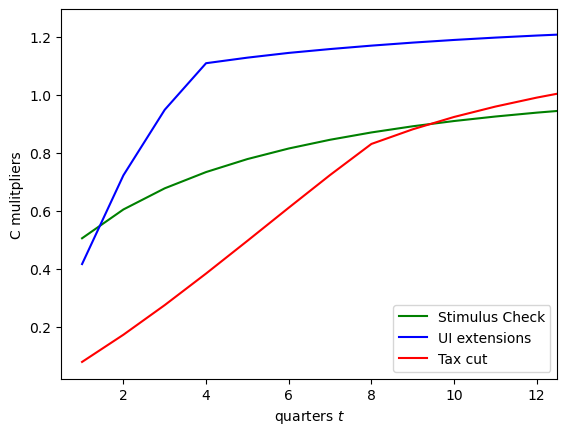

In [29]:
plt.plot(
    np.arange(horizon_length) + 1,
    multipliers_transfers,
    label="Stimulus Check",
    color="green",
)
plt.plot(
    np.arange(horizon_length) + 1,
    multipliers_UI_extend,
    label="UI extensions",
    color="blue",
)
plt.plot(
    np.arange(horizon_length) + 1, multipliers_tax_cut, label="Tax cut", color="red"
)
plt.legend(loc="lower right")
plt.ylabel("C mulitpliers")
plt.xlabel("quarters $t$")
plt.xlim(0.5, 12.5)
plt.show()

In [30]:
# Plotting functions imported from HANK-and-SAM-tutorial-utils.py
# See that file for: plot_multipliers_three_experiments, plot_consumption_irfs_three_experiments, etc.

---

## Multipliers by Monetary Policy Regime

<a id="multipliers-by-monetary-policy-regime"></a>

📄 **Paper**: [Section 5: HANK-SAM Model](https://llorracc.github.io/HAFiscal-Public/#x1-340005) | [Figure 5](https://llorracc.github.io/HAFiscal-Public/#x1-34005r5)

Comparing multipliers under three monetary policy regimes:

| Regime | Description | Multiplier Effect |
|--------|-------------|-------------------|
| **Taylor Rule** | $i_t = r^* + \phi_\pi \pi_t + \phi_y \tilde{y}_t$ | Baseline — monetary tightening dampens stimulus |
| **Fixed Nominal Rate** | $i_t = \bar{i}$ (ZLB/liquidity trap) | Higher multipliers — no crowding out |
| **Fixed Real Rate** | $r_t = r^*$ (full accommodation) | Highest multipliers — equivalent to PE |

**Key insight**: Monetary policy is crucial for fiscal effectiveness. At the zero lower bound (fixed nominal rate), fiscal multipliers are substantially larger because the central bank cannot offset the stimulus.


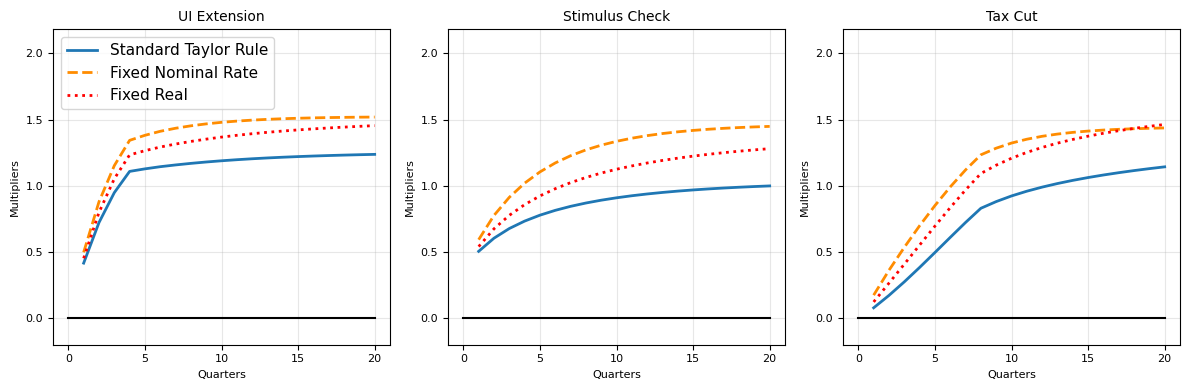

In [31]:
plot_multipliers_three_experiments(
    multipliers_transfers,
    multipliers_transfers_fixed_nominal_rate,
    multipliers_transfers_fixed_real_rate,
    multipliers_UI_extend,
    multipliers_UI_extensions_fixed_nominal_rate,
    multipliers_UI_extensions_fixed_real_rate,
    multipliers_tax_cut,
    multipliers_tax_cut_fixed_nominal_rate,
    multipliers_tax_cut_fixed_real_rate,
)

### Interpretation: Fiscal Multipliers

**Key Findings from the Multipliers Plot:**

1. **UI Extensions have the highest multipliers** (~1.2-1.5)
   - Targets unemployed workers who have high MPCs
   - Automatic stabilizer properties

2. **Stimulus Checks are second-best** (~1.0-1.3)
   - Broad-based but includes some low-MPC households
   - Fast delivery is an advantage

3. **Tax Cuts have the lowest multipliers** (~0.7-0.9)
   - Spread across all workers (poor targeting)
   - Labor supply distortions reduce effectiveness

---

### 🛠️ HARK Connection: MPC Heterogeneity

The **marginal propensity to consume (MPC)** varies dramatically across households. HARK models capture this through:

| Household Type | Typical MPC | Why? |
|----------------|-------------|------|
| **Unemployed, low wealth** | 0.6–0.9 | Hand-to-mouth, liquidity constrained |
| **Employed, low wealth** | 0.3–0.5 | Some buffer stock, but still constrained |
| **Employed, high wealth** | 0.05–0.15 | Smooth consumption over time |

This distribution is why **targeting matters**: UI extensions reach the 0.6–0.9 MPC households, while tax cuts average across all workers.

**Further reading on MPC distributions:**
- [Fagereng, Holm, Natvik (2021)](https://www.aeaweb.org/articles?id=10.1257/mac.20190211) — MPC heterogeneity from Norwegian data
- [HARK's ConsIndShockModel](https://docs.econ-ark.org/reference/ConsumptionSaving/ConsIndShockModel.html) — Theoretical foundations
- [Carroll et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0304393217300466) — Distribution of wealth and MPC


In [32]:
# Plotting function imported from HANK-and-SAM-tutorial-utils.py

# Consumption response to each policy under various monetary policy rules

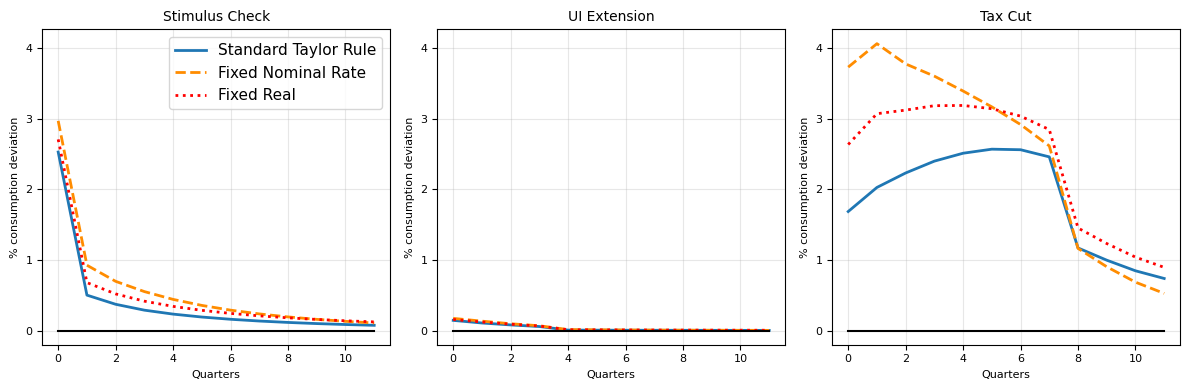

In [33]:
plot_consumption_irfs_three_experiments(
    irfs_UI_extend,
    irfs_UI_extend_fixed_nominal_rate,
    irfs_UI_extension_fixed_real_rate,
    irfs_transfer,
    irfs_transfer_fixed_nominal_rate,
    irfs_transfer_fixed_real_rate,
    irfs_tau,
    irfs_tau_fixed_nominal_rate,
    irfs_tau_fixed_real_rate,
    C_ss,
)

### Interpretation: Consumption Dynamics

**What the IRFs Show:**

The impulse response functions reveal the **timing** of consumption effects:

1. **UI Extensions**: Gradual buildup as benefits flow to unemployed
2. **Stimulus Checks**: Front-loaded response (immediate spending + splurge)
3. **Tax Cuts**: Smaller, more spread out response

**Fixed Rate vs Taylor Rule:**
- Under fixed rates, consumption responses are larger and more persistent
- The Taylor rule "crowds out" private consumption via higher interest rates


In [34]:
# Plotting function imported from HANK-and-SAM-tutorial-utils.py

# Consumption response to each fiscal policy under a standard Taylor rule

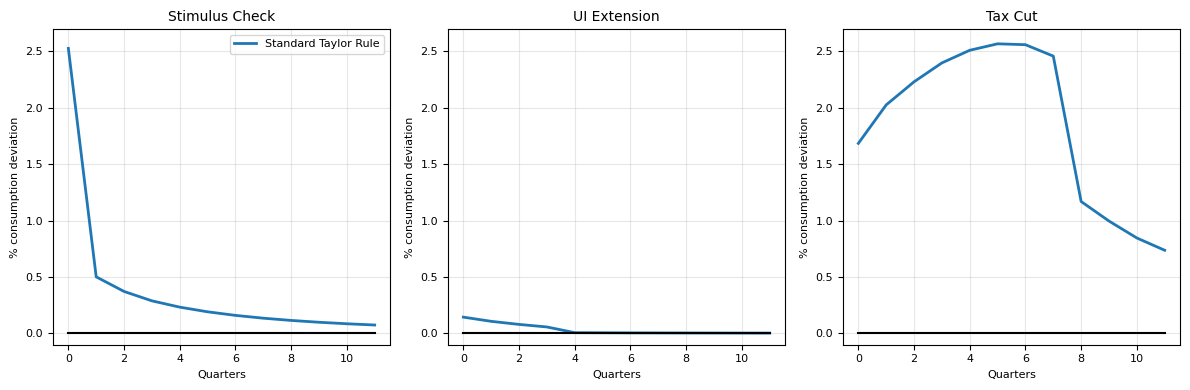

In [35]:
plot_consumption_irfs_three(irfs_transfer, irfs_UI_extend, irfs_tau, C_ss)

In [36]:
# Individual IRF plots using imported function

y_max = max(100 * irfs_tau_fixed_nominal_rate['C'][:12] / C_ss) * 1.05
plot_consumption_irf(irfs_transfer, irfs_transfer_fixed_nominal_rate, irfs_transfer_fixed_real_rate, C_ss, y_max, "Stimulus Check", legend=True)
plot_consumption_irf(irfs_UI_extend, irfs_UI_extend_fixed_nominal_rate, irfs_UI_extension_fixed_real_rate, C_ss, y_max, "UI Extension")
plot_consumption_irf(irfs_tau, irfs_tau_fixed_nominal_rate, irfs_tau_fixed_real_rate, C_ss, y_max, "Tax Cut")

In [37]:
# Multiplier plots using imported function (currently commented out)

In [38]:
"""
fig_dir = "figures/"
y_max =  1.9
plot_consumption_multipliers( multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, y_max, "HANK_transfer_multiplier")
plot_consumption_multipliers( multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, y_max, "HANK_UI_multiplier")
plot_consumption_multipliers( multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate, y_max, "HANK_tax_multiplier")
"""

'\nfig_dir = "figures/"\ny_max =  1.9\nplot_consumption_multipliers( multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, y_max, "HANK_transfer_multiplier")\nplot_consumption_multipliers( multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, y_max, "HANK_UI_multiplier")\nplot_consumption_multipliers( multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate, y_max, "HANK_tax_multiplier")\n'

---

## Summary: Comparison to Main Paper Results

<a id="summary-comparison-to-main-paper-results"></a>

### Key Takeaways

1. **UI extensions dominate other policies** — Highest multiplier (~1.2-1.5) due to targeting high-MPC unemployed households and beneficial anticipation effects

2. **Stimulus checks are second-best** — Broad-based delivery is fast but includes low-MPC households, reducing effectiveness

3. **Tax cuts are least effective** — Only benefit employed workers who have lower MPCs; no anticipation channel

4. **Monetary policy matters enormously** — Multipliers are 20-50% higher under accommodative monetary policy (fixed rates) vs. active Taylor rule

### Partial Equilibrium vs. General Equilibrium

| Framework | Key Assumptions | Use Case |
|-----------|-----------------|----------|
| **Partial Equilibrium** ([Section 4](https://llorracc.github.io/HAFiscal-Public/#x1-250004)) | Prices/wages fixed, no monetary response | Isolate household heterogeneity effects |
| **General Equilibrium** ([Section 5](https://llorracc.github.io/HAFiscal-Public/#x1-340005)) | Endogenous prices, monetary policy response | Realistic policy analysis |

The GE results in this tutorial validate the PE findings: the ranking of policies is preserved, though levels differ based on monetary regime.

### Paper Multipliers ([Table 6](https://llorracc.github.io/HAFiscal-Public/#x1-30004r6))

| Policy | PE Multiplier | GE (Taylor) | GE (Fixed Rate) |
|--------|---------------|-------------|-----------------|
| UI Extension | ~1.4 | ~1.2 | ~1.4 |
| Stimulus Check | ~1.1 | ~0.9 | ~1.1 |
| Tax Cut | ~0.8 | ~0.7 | ~0.9 |

---

## Next Steps

🎛️ **Try the Interactive Dashboard**: Explore how parameters affect multipliers in real-time:
- [`dashboard/app.ipynb`](dashboard/app.ipynb) — local Jupyter/Voila
- [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llorracc/HAFiscal-Latest/master?urlpath=voila%2Frender%2Fdashboard%2Fapp.ipynb) — launch in browser (no installation)

**What you can explore in the dashboard:**
- Increase `φ_π` (inflation response) → watch multipliers shrink as monetary policy tightens
- Set `ρ_r` close to 1 (high interest rate smoothing) → multipliers increase with sluggish monetary response
- Compare fixed nominal vs. fixed real rate regimes

---

## HARK Resources for Further Learning

<a id="hark-resources-for-further-learning"></a>

### Getting Started with HARK

| Resource | Description | Best For |
|----------|-------------|----------|
| [Gentle Introduction to HARK](https://econ-ark.org/materials/gentle-intro-to-hark/) | Beginner-friendly walkthrough | First-time users |
| [HARK Quick Start Guide](https://docs.econ-ark.org/guides/quick_start.html) | Installation & basic usage | Setup |
| [HARK API Reference](https://docs.econ-ark.org/reference/index.html) | Complete function documentation | Reference |

### Consumption-Saving Models

| Model | Description | Relevance |
|-------|-------------|-----------|
| [IndShockConsumerType](https://econ-ark.org/materials/indshockconsumertype/) | Individual income shocks | Foundation for household Jacobians |
| [ConsAggShockModel](https://docs.econ-ark.org/reference/ConsumptionSaving/ConsAggShockModel.html) | Aggregate + idiosyncratic shocks | Business cycle analysis |
| [PerfForesightConsumerType](https://econ-ark.org/materials/perfforesightconsumertype/) | No uncertainty baseline | Understanding consumption smoothing |

### Advanced Topics

| Topic | Resource | Description |
|-------|----------|-------------|
| **Heterogeneous agent macro** | [Krusell-Smith Model](https://econ-ark.org/materials/krusell-smith/) | Classic HA macro model |
| **Fiscal policy** | [Fiscal Rules & Automatic Stabilizers](https://econ-ark.org/materials/) | Related policy analysis |
| **Sequence-space methods** | [Auclert et al. (2021)](https://github.com/shade-econ/sequence-jacobian) | GE solution technique |

### Example Notebooks (DemARK)

The [DemARK repository](https://github.com/econ-ark/DemARK) contains Jupyter notebooks demonstrating HARK:

- **Consumption functions**: How policy functions vary with wealth and income
- **Simulation**: Generating artificial panel data
- **Estimation**: Matching model to empirical moments

### Econ-ARK Journeys

For structured learning paths, see [econ-ark.org/journeys](https://econ-ark.org/journeys/):
- 🎓 **Student** — Course materials and problem sets
- 🏛️ **Policy** — Central bank & fiscal policy applications
- 🔬 **Researcher** — Advanced modeling techniques

---

📄 **Full paper**: [Welfare and Spending Effects of Consumption Stimulus Policies](https://llorracc.github.io/HAFiscal-Public/)

📦 **Code repository**: [github.com/llorracc/HAFiscal](https://github.com/llorracc/HAFiscal)

🛠️ **HARK toolkit**: [github.com/econ-ark/HARK](https://github.com/econ-ark/HARK) | [econ-ark.org](https://econ-ark.org)
